SETUP

In [3]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [4]:
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,
                                LemmatizerModel, StopWordsCleaner)
from pyspark.sql.functions import length
import pyspark.sql.functions as F

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.executor.memory", "12g")\
    .config("spark.executor.cores", "3")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
            "fs.s3a.aws.credentials.provider",
            "com.amazonaws.auth.ContainerCredentialsProvider"
    )\
    .getOrCreate()

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c3e1ffcb-f042-463c-9791-c46ebebb2fb6;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

3.4.0


In [33]:
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws, when, length, count
from pyspark.ml.feature import Tokenizer, StopWordsRemover,OneHotEncoder, StringIndexer, IndexToString, VectorAssembler,HashingTF, IDF
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import Finisher, DocumentAssembler
from sagemaker.spark.processing import PySparkProcessor
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.ml import Pipeline, Model
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from sklearn.metrics import confusion_matrix,roc_curve, auc

DATA CLEANING

In [34]:
df = spark.read.parquet("s3a://project-group34/project/submissions/sentiment_emotion_submissions/")

In [35]:
df.printSchema()

root
 |-- emotion: string (nullable = true)
 |-- sentiment_score: float (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- text: string (nullable = true)
 |-- score: long (nullable = true)
 |-- num_comments: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- post_length: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- has_media: boolean (nullable = true)



In [36]:
#check missing values
missing_vals = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_vals.show()

+-------+---------------+---------+----+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+
|emotion|sentiment_score|subreddit|text|score|num_comments|over_18|is_self|is_video|post_length|hour_of_day|day_of_week|day_of_month|month|year|has_media|
+-------+---------------+---------+----+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+
|    734|            734|        0|   0|    0|           0|      0|      0|       0|          0|          0|          0|           0|    0|   0|        0|
+-------+---------------+---------+----+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+



In [37]:
# Drop rows with any missing values
df = df.dropna()

In [38]:
missing_vals = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_vals.show()

+-------+---------------+---------+----+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+
|emotion|sentiment_score|subreddit|text|score|num_comments|over_18|is_self|is_video|post_length|hour_of_day|day_of_week|day_of_month|month|year|has_media|
+-------+---------------+---------+----+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+
|      0|              0|        0|   0|    0|           0|      0|      0|       0|          0|          0|          0|           0|    0|   0|        0|
+-------+---------------+---------+----+-----+------------+-------+-------+--------+-----------+-----------+-----------+------------+-----+----+---------+



In [39]:
#convert to pandas dataframe
pandas_df = df.toPandas()

In [12]:
#get the statistics of num_comments column
pandas_df["num_comments"].describe()

count    875024.000000
mean         26.623398
std         250.544172
min           0.000000
25%           0.000000
50%           1.000000
75%           8.000000
max       35446.000000
Name: num_comments, dtype: float64

In [13]:
#calculate the records greater than mean value
len(pandas_df[pandas_df["num_comments"] >= 27])

96353

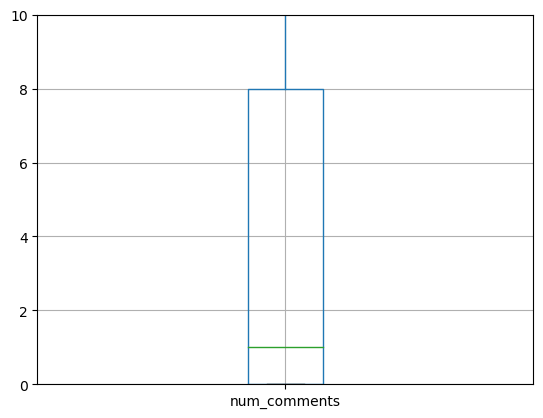

In [18]:
#creating boxplot
b_plot = pandas_df.boxplot(column = 'num_comments') 
b_plot.set_ylim(0,10)
plt.show()

In [40]:
# Add a new column 'is_popular'
df = df.withColumn('is_popular', when(col('num_comments') >= 27, 1).otherwise(0))

In [41]:
#Drop num_comments column
df = df.drop("num_comments")

In [42]:
df.printSchema()

root
 |-- emotion: string (nullable = true)
 |-- sentiment_score: float (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- text: string (nullable = true)
 |-- score: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- post_length: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- has_media: boolean (nullable = true)
 |-- is_popular: integer (nullable = false)



In [43]:
# get count of values in is_popular column by groupBy 
popularity_counts = df.groupBy("is_popular").count()

# Display the counts
popularity_counts.show()

+----------+------+
|is_popular| count|
+----------+------+
|         1| 96353|
|         0|778671|
+----------+------+



In [44]:
#convert it to pandas
popularity_counts_pd = popularity_counts.toPandas()

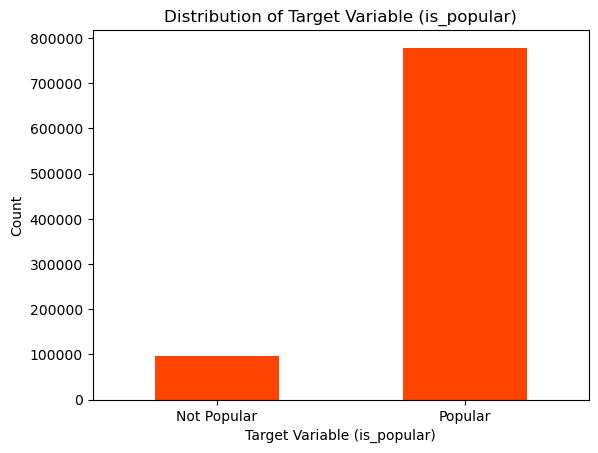

In [50]:
# Plot a bar graph
popularity_counts_pd.plot(kind='bar', x='is_popular', y='count', color=['#ff4301', '#ff4301'], legend=False)
plt.xlabel('Target Variable (is_popular)')
plt.ylabel('Count')
plt.title('Distribution of Target Variable (is_popular)')
plt.xticks(ticks=[1, 0], labels=['Popular','Not Popular'], rotation=0)
plt.savefig("../../data/plots/is_popular_distribution.png", dpi=300)
plt.show()

Downsampling

In [51]:
# Separate the data into two DataFrames based on the 'is_popular' value
popular_df = df.filter(F.col("is_popular") == 1)
not_popular_df = df.filter(F.col("is_popular") == 0)

In [52]:
# Downsample the majority class (is_popular = 0) to match the count of the minority class (is_popular = 1)
downsampled_not_popular_df = not_popular_df.sample(False, popular_df.count() / not_popular_df.count())

In [53]:
# Combine the downsampled majority class with the minority class
downsampled_df = popular_df.union(downsampled_not_popular_df)

In [65]:
# Check the counts after downsampling
downsampled_df_table=downsampled_df.groupBy("is_popular").count().toPandas()
downsampled_df_table

,is_popular,count
0,1,96353
1,0,96314


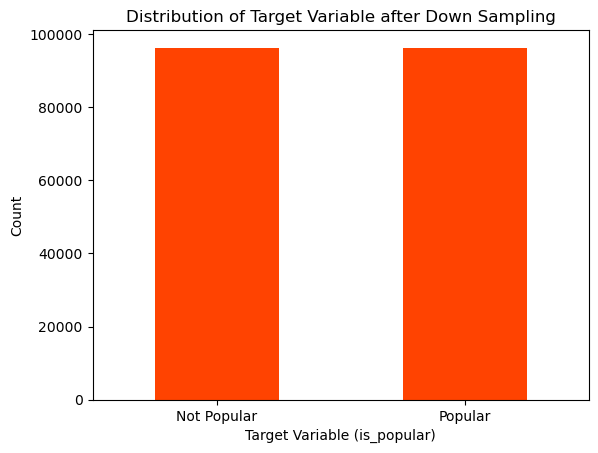

In [67]:
# Plot a bar graph
downsampled_df_table.plot(kind='bar', x='is_popular', y='count', color=['#ff4301', '#ff4301'], legend=False)
plt.xlabel('Target Variable (is_popular)')
plt.ylabel('Count')
plt.title('Distribution of Target Variable after Down Sampling')
plt.xticks(ticks=[1, 0], labels=['Popular','Not Popular'], rotation=0)
plt.savefig("../../data/plots/is_popular_distribution_downsampled.png", dpi=300)
plt.show()

In [19]:
downsampled_df.printSchema()

root
 |-- emotion: string (nullable = true)
 |-- sentiment_score: float (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- text: string (nullable = true)
 |-- score: long (nullable = true)
 |-- over_18: boolean (nullable = true)
 |-- is_self: boolean (nullable = true)
 |-- is_video: boolean (nullable = true)
 |-- post_length: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- has_media: boolean (nullable = true)
 |-- is_popular: integer (nullable = false)



In [20]:
# Tokenize text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_df = tokenizer.transform(downsampled_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_no_stopwords = remover.transform(tokenized_df)

# Vectorize words
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures")
featurizedData = hashingTF.transform(df_no_stopwords)

# Optionally, use IDF to rescale the feature vectors
idf = IDF(inputCol="rawFeatures", outputCol="features")
rescaledData = idf.fit(featurizedData).transform(featurizedData)

In [21]:
#drop columns unwanted columns
rescaledData = rescaledData.drop(*["words", "filtered_words", "rawFeatures"])

In [22]:
#convert datatype to string
rescaledData = rescaledData.withColumn("over_18", col("over_18").cast("string"))
rescaledData = rescaledData.withColumn("is_self", col("is_self").cast("string"))
rescaledData = rescaledData.withColumn("is_video", col("is_video").cast("string"))
rescaledData = rescaledData.withColumn("has_media", col("has_media").cast("string"))
rescaledData = rescaledData.withColumn("is_popular", col("is_popular").cast("string"))
rescaledData = rescaledData.withColumn("emotion", col("emotion").cast("string"))
rescaledData

DataFrame[emotion: string, sentiment_score: float, subreddit: string, text: string, score: bigint, over_18: string, is_self: string, is_video: string, post_length: int, hour_of_day: int, day_of_week: int, day_of_month: int, month: int, year: int, has_media: string, is_popular: string, features: vector]

In [23]:
# Show the updated schema
rescaledData.printSchema()

root
 |-- emotion: string (nullable = true)
 |-- sentiment_score: float (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- text: string (nullable = true)
 |-- score: long (nullable = true)
 |-- over_18: string (nullable = true)
 |-- is_self: string (nullable = true)
 |-- is_video: string (nullable = true)
 |-- post_length: integer (nullable = true)
 |-- hour_of_day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- has_media: string (nullable = true)
 |-- is_popular: string (nullable = false)
 |-- features: vector (nullable = true)



In [24]:
rescaledData.write.parquet("s3a://project-group34/project/submissions/cleaned_ML_3/", mode="overwrite")

23/11/30 20:53:35 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


spark job

In [52]:
%%time
# Setup the PySpark processor to run the job. Note the instance type and instance count parameters. SageMaker will create these many instances of this type for the spark job.
role = sagemaker.get_execution_role()
spark_processor = PySparkProcessor(
    base_job_name="sm-spark-project",
    framework_version="3.3",
    role=role,
    instance_count=8,
    instance_type="ml.m5.xlarge",
    max_runtime_in_seconds=21600,
)

# s3 paths
session = sagemaker.Session()
output_prefix_logs = f"spark_logs"

configuration = [
    {
        "Classification": "spark-defaults",
        "Properties": {"spark.executor.memory": "12g", "spark.executor.cores": "4"},
    }
]

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
CPU times: user 89.2 ms, sys: 426 µs, total: 89.6 ms
Wall time: 135 ms


PREPROCESSING JOB

In [26]:
%%writefile ./code/preprocess_ml3.py

import sys
import os
import logging
import argparse
# Import pyspark and build Spark session
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline, Model
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import length


logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():
    
    parser = argparse.ArgumentParser(description="app inputs and outputs")
    parser.add_argument("--s3_dataset_path", type=str, help="Path of dataset in S3")    
    args = parser.parse_args()

    spark = SparkSession.builder \
    .appName("Spark ML")\
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3")\
    .getOrCreate()
    
    logger.info(f"Spark version: {spark.version}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

    # Downloading the data from S3 into a Dataframe
    logger.info(f"going to read {args.s3_dataset_path}")
    rescaledData = spark.read.parquet(args.s3_dataset_path, header=True)
    vals = ["movies", "anime"]
    rescaledData = rescaledData.where(col("subreddit").isin(vals))
    
    train_data, test_data, val_data = rescaledData.randomSplit([0.8, 0.15, 0.05], seed=1140)
    
    # Print the number of records in each dataset
    logger.info("Number of training records: " + str(train_data.count()))
    logger.info("Number of testing records: " + str(test_data.count()))
    logger.info("Number of validation records: " + str(val_data.count()))
    
    stringIndexer_over_18 = StringIndexer(inputCol="over_18", outputCol="over_18_ix")
    stringIndexer_is_self = StringIndexer(inputCol="is_self", outputCol="is_self_ix")
    stringIndexer_is_video = StringIndexer(inputCol="is_video", outputCol="is_video_ix")
    stringIndexer_has_media = StringIndexer(inputCol="has_media", outputCol="has_media_ix")
    stringIndexer_subreddit = StringIndexer(inputCol="subreddit", outputCol="subreddit_ix")
    stringIndexer_emotion = StringIndexer(inputCol="emotion", outputCol="emotion_ix")
    stringIndexer_is_popular = StringIndexer(inputCol="is_popular", outputCol="is_popular_ix")
    
    onehot_over_18 = OneHotEncoder(inputCol="over_18_ix", outputCol="over_18_vec")
    onehot_is_self = OneHotEncoder(inputCol="is_self_ix", outputCol="is_self_vec")
    onehot_is_video = OneHotEncoder(inputCol="is_video_ix", outputCol="is_video_vec")
    onehot_has_media = OneHotEncoder(inputCol="has_media_ix", outputCol="has_media_vec")
    onehot_has_subreddit = OneHotEncoder(inputCol="subreddit_ix", outputCol="subreddit_vec")
    
    vectorAssembler_features = VectorAssembler(
                                    inputCols=["emotion_ix","subreddit_vec","score","over_18_vec","is_self_vec",
                                               "is_video_vec","post_length","hour_of_day","day_of_week",
                                               "day_of_month", "month","year", "has_media_vec", "features"],
                                    outputCol="combined_features")

    # Define the stages for the pipeline
    stages = [
        stringIndexer_is_popular,
        stringIndexer_emotion,
        stringIndexer_subreddit, 
        stringIndexer_over_18, 
        stringIndexer_is_self, 
        stringIndexer_is_video, 
        stringIndexer_has_media,
        onehot_over_18,
        onehot_is_self,
        onehot_is_video,
        onehot_has_media,
        onehot_has_subreddit,
        vectorAssembler_features
    ]

    # Define the pipeline without the classifier and evaluator
    pipeline = Pipeline(stages=stages)

    # Fit the preprocessing part of the pipeline
    pipeline_fit = pipeline.fit(train_data)

    # Transform the data
    transformed_train_data = pipeline_fit.transform(train_data)
    transformed_test_data = pipeline_fit.transform(test_data)
    
    transformed_train_data.write.parquet("s3a://project-group34/project/submissions/preprocessed_ML/train_3/", mode="overwrite")
    transformed_test_data.write.parquet("s3a://project-group34/project/submissions/preprocessed_ML/test_3/", mode="overwrite")
    
if __name__ == "__main__":
    main()

Overwriting ./code/preprocess_ml3.py


In [ ]:
%%time
bucket = "project-group34"
s3_path = "s3a://project-group34/project/submissions/cleaned_ML_3/"

# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/preprocess_ml3.py",
    arguments=[
        "--s3_dataset_path",
        s3_path,
    ],
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)

INFO:sagemaker:Creating processing-job with name sm-spark-project-2023-11-30-20-54-24-013


.........................................................................................................!CPU times: user 523 ms, sys: 33.6 ms, total: 557 ms
Wall time: 8min 55s


MODEL 1 - LOGISTIC REGRESSION

In [37]:
%%writefile ./code/ml_train_lr3.py

import sys
import os
import logging
import argparse
# Import pyspark and build Spark session
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline, Model
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import length


logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():

    spark = (SparkSession.builder\
             .appName("PySparkApp")\
             .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")\
             .config(
                    "fs.s3a.aws.credentials.provider",
                    "com.amazonaws.auth.ContainerCredentialsProvider",
                )\
    .getOrCreate()
)
    
    logger.info(f"Spark version: {spark.version}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

    # Downloading the data from S3 into a Dataframe
    transformed_train_data = spark.read.parquet("s3a://project-group34/project/submissions/preprocessed_ML/train_3/")
    transformed_test_data = spark.read.parquet("s3a://project-group34/project/submissions/preprocessed_ML/test_3/")
    
    # RandomForestClassifier without hyperparameter tuning
    lr_classifier = LogisticRegression(labelCol="is_popular_ix", 
                                           featuresCol="combined_features")
    labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedPopularity", 
                               labels=["0", "1"])

    # Add the best model and labelConverter to the pipeline
    pipeline = Pipeline(stages=[lr_classifier, 
                                labelConverter])
    
    # Fit the entire pipeline
    pipeline_fit = pipeline.fit(transformed_train_data)
    train_predictions = pipeline_fit.transform(transformed_train_data)

    # Transform the data with the best model
    test_predictions = pipeline_fit.transform(transformed_test_data)
    
    train_predictions.write.parquet("s3a://project-group34/project/submissions/lr/train_pred_3/", mode="overwrite")    
    test_predictions.write.parquet("s3a://project-group34/project/submissions/lr/test_pred_3/", mode="overwrite")
    pipeline_fit.save("s3a://project-group34/project/submissions/lr/model1/")
    
    logger.info(f"all done...")
    
if __name__ == "__main__":
    main()

Overwriting ./code/ml_train_lr3.py


In [38]:
%%time
bucket = "project-group34"

# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/ml_train_lr3.py",
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)

INFO:sagemaker:Creating processing-job with name sm-spark-project-2023-11-30-21-46-50-083


.........................................................................................................................................................!CPU times: user 629 ms, sys: 47.9 ms, total: 677 ms
Wall time: 12min 56s


MODEL 2- DECISION TREE

In [ ]:
%%writefile ./code/ml_train_dt3.py

import sys
import os
import logging
import argparse
# Import pyspark and build Spark session
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import GBTClassifier,LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline, Model
import sagemaker
from pyspark.sql.functions import lower, regexp_replace, col, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import length


logging.basicConfig(format='%(asctime)s,%(levelname)s,%(module)s,%(filename)s,%(lineno)d,%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

def main():

    spark = (SparkSession.builder\
             .appName("PySparkApp")\
             .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")\
             .config(
                    "fs.s3a.aws.credentials.provider",
                    "com.amazonaws.auth.ContainerCredentialsProvider",
                )\
    .getOrCreate()
)
    
    logger.info(f"Spark version: {spark.version}")
    
    # This is needed to save RDDs which is the only way to write nested Dataframes into CSV format
    sc = spark.sparkContext
    sc._jsc.hadoopConfiguration().set(
        "mapred.output.committer.class", "org.apache.hadoop.mapred.FileOutputCommitter"
    )

    # Downloading the data from S3 into a Dataframe
    transformed_train_data = spark.read.parquet("s3a://project-group34/project/submissions/preprocessed_ML/train_3/")
    transformed_test_data = spark.read.parquet("s3a://project-group34/project/submissions/preprocessed_ML/test_3/")
    
    # RandomForestClassifier without hyperparameter tuning
    dt_classifier = DecisionTreeClassifier(labelCol="is_popular_ix", 
                                           featuresCol="combined_features")
    labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedPopularity", 
                               labels=["0", "1"])

    # Add the best model and labelConverter to the pipeline
    pipeline = Pipeline(stages=[dt_classifier, 
                                labelConverter])
    
    # Fit the entire pipeline
    pipeline_fit = pipeline.fit(transformed_train_data)
    train_predictions = pipeline_fit.transform(transformed_train_data)

    # Transform the data with the best model
    test_predictions = pipeline_fit.transform(transformed_test_data)
    
    train_predictions.write.parquet("s3a://project-group34/project/submissions/dt/train_pred_3/", mode="overwrite")    
    test_predictions.write.parquet("s3a://project-group34/project/submissions/dt/test_pred_3/", mode="overwrite")
    pipeline_fit.save("s3a://project-group34/project/submissions/dt/model1/")
    
    logger.info(f"all done...")
    
if __name__ == "__main__":
    main()

In [ ]:
%%time
bucket = "project-group34"

# run the job now, the arguments array is provided as command line to the Python script (Spark code in this case).
spark_processor.run(
    submit_app="./code/ml_train_dt3.py",
    spark_event_logs_s3_uri="s3://{}/{}/spark_event_logs".format(bucket, output_prefix_logs),
    logs=False,
    configuration=configuration
)

EVALUATION

In [6]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

# Import pyspark and build Spark session
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","16G")\
    .config("spark.executor.memory", "12g")\
    .config("spark.executor.cores", "3")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")\
    .config(
            "fs.s3a.aws.credentials.provider",
            "com.amazonaws.auth.ContainerCredentialsProvider"
    )\
    .getOrCreate()

print(spark.version)

3.4.0


In [8]:
transformed_train_lr = spark.read.parquet("s3a://project-group34/project/submissions/lr/train_pred_3/")

23/12/01 03:49:00 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [9]:
transformed_test_lr = spark.read.parquet("s3a://project-group34/project/submissions/lr/test_pred_3/")

In [10]:
transformed_train_dt = spark.read.parquet("s3a://project-group34/project/submissions/dt/train_pred_3/")

In [11]:
transformed_test_dt = spark.read.parquet("s3a://project-group34/project/submissions/dt/test_pred_3/")

In [12]:
evaluator = MulticlassClassificationEvaluator(labelCol="is_popular_ix", predictionCol="prediction", metricName="accuracy")
accuracy_lr_train = evaluator.evaluate(transformed_train_lr)
accuracy_lr_test = evaluator.evaluate(transformed_test_lr)
accuracy_dt_train = evaluator.evaluate(transformed_train_dt)
accuracy_dt_test = evaluator.evaluate(transformed_test_dt)

In [13]:
# Function to calculate metrics
def compute_metrics(dataset, label_col, prediction_col):
    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col)
    accuracy = evaluator.evaluate(dataset, {evaluator.metricName: "accuracy"})
    f1 = evaluator.evaluate(dataset, {evaluator.metricName: "f1"})
    precision = evaluator.evaluate(dataset, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(dataset, {evaluator.metricName: "weightedRecall"})
    return accuracy, f1, precision, recall

# Calculate metrics for the default model
accuracy_lr_train, f1_lr_train, precision_lr_train, recall_lr_train = compute_metrics(transformed_train_lr, "is_popular_ix", "prediction")
accuracy_lr_test, f1_lr_test, precision_lr_test, recall_lr_test = compute_metrics(transformed_test_lr, "is_popular_ix", "prediction")

# Calculate metrics for the model with hyperparameters
accuracy_dt_train, f1_dt_train, precision_dt_train, recall_dt_train = compute_metrics(transformed_train_dt, "is_popular_ix", "prediction")
accuracy_dt_test, f1_dt_test, precision_dt_test, recall_dt_test = compute_metrics(transformed_test_dt, "is_popular_ix", "prediction")

In [14]:
# Create a DataFrame with the metrics
metrics_data = {
    'Model': ['Logistic Regression', 'Decision Tree'],
    'Accuracy Train': [accuracy_lr_train, accuracy_dt_train],
    'Accuracy Test': [accuracy_lr_test, accuracy_dt_test],
    'F1 Score Train': [f1_lr_train, f1_dt_train],
    'F1 Score Test': [f1_lr_test, f1_dt_test],
    'Precision Train': [precision_lr_train, precision_dt_train],
    'Precision Test': [precision_lr_test, precision_dt_test],
    'Recall Train': [recall_lr_train, recall_dt_train],
    'Recall Test': [recall_lr_test, recall_dt_test]
}

metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Model,Accuracy Train,Accuracy Test,F1 Score Train,F1 Score Test,Precision Train,Precision Test,Recall Train,Recall Test
0,Logistic Regression,0.934118,0.751146,0.934017,0.750600,0.934704,0.751036,0.934118,0.751146
1,Decision Tree,0.874378,0.872044,0.874431,0.872105,0.874632,0.872316,0.874378,0.872044


In [22]:
y_pred_lr_test = [row['prediction'] for row in transformed_test_lr.select("prediction").collect()]
y_orig_lr_test = [row['is_popular_ix'] for row in transformed_test_lr.select("is_popular_ix").collect()]
y_pred_dt_test = [row['prediction'] for row in transformed_test_dt.select("prediction").collect()]
y_orig_dt_test = [row['is_popular_ix'] for row in transformed_test_dt.select("is_popular_ix").collect()]

In [23]:
#create confusion matrix
cm_lr = confusion_matrix(y_orig_lr_test, y_pred_lr_test)
cm_dt = confusion_matrix(y_orig_dt_test, y_pred_dt_test)

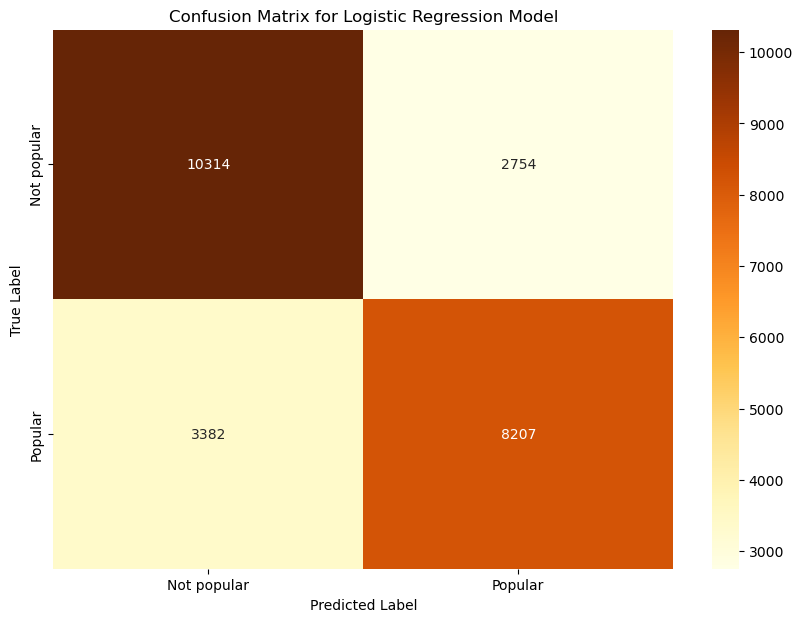

In [25]:
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap=sns.color_palette("YlOrBr", as_cmap=True), yticklabels=["Not popular", "Popular"], xticklabels=["Not popular", "Popular"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.savefig("../../data/plots/confusion_matrix_lr_classification.png", dpi=300)
plt.show()

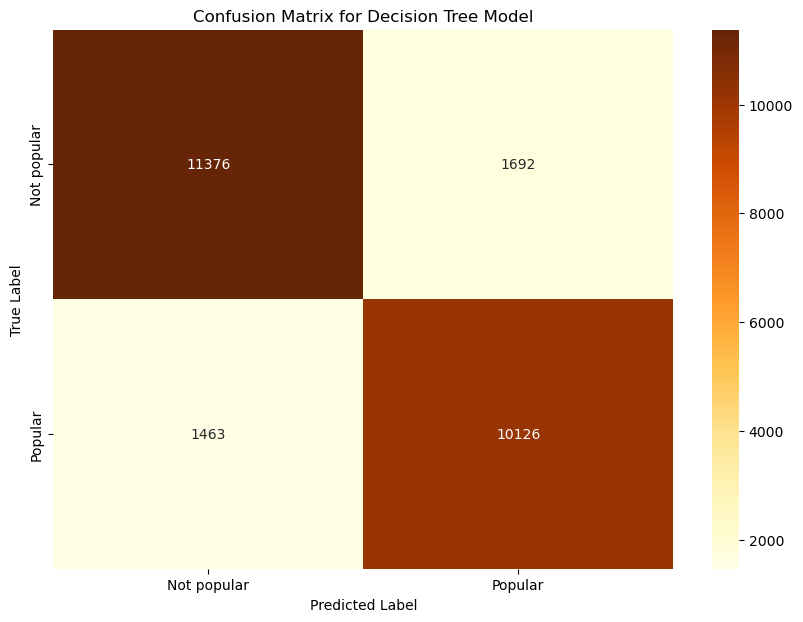

In [26]:
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_dt, annot=True, fmt="d", cmap=sns.color_palette("YlOrBr", as_cmap=True), yticklabels=["Not popular", "Popular"], xticklabels=["Not popular", "Popular"])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Decision Tree Model')
plt.savefig("../../data/plots/confusion_matrix_dt_classification.png", dpi=300)
plt.show()

In [29]:
# Function to extract the probability of the positive class
get_probability = udf(lambda v: float(v[1]), FloatType())

# Add a new column with the probability for the positive class
roc_data_lr = transformed_test_lr.withColumn("positive_probability", get_probability("probability"))
roc_data_dt = transformed_test_dt.withColumn("positive_probability", get_probability("probability"))

# Collect the data
roc_data_lr = roc_data_lr.select("positive_probability", "is_popular_ix").toPandas()
roc_data_dt = roc_data_dt.select("positive_probability", "is_popular_ix").toPandas()

# Probabilities and actual labels
y_probs_lr = roc_data_lr['positive_probability']
y_orig_lr = roc_data_lr['is_popular_ix']
y_probs_dt = roc_data_dt['positive_probability']
y_orig_dt = roc_data_dt['is_popular_ix']

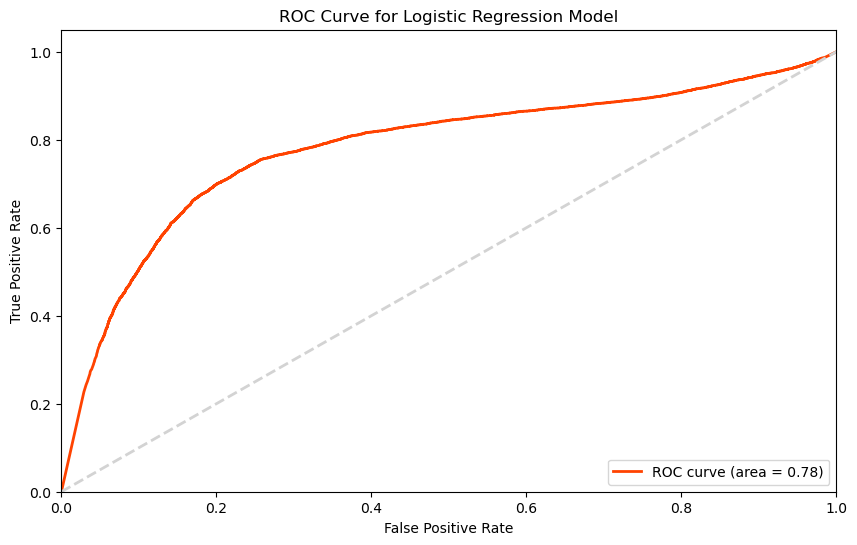

In [31]:
fpr, tpr, thresholds = roc_curve(y_orig_lr, y_probs_lr) #ROC curve points
roc_auc_lr = auc(fpr, tpr) # AUC

# Plotting roc curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='#ff4301', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend(loc="lower right")
plt.savefig("../../data/plots/ROC_lr_classification.png", dpi=300)
plt.show()


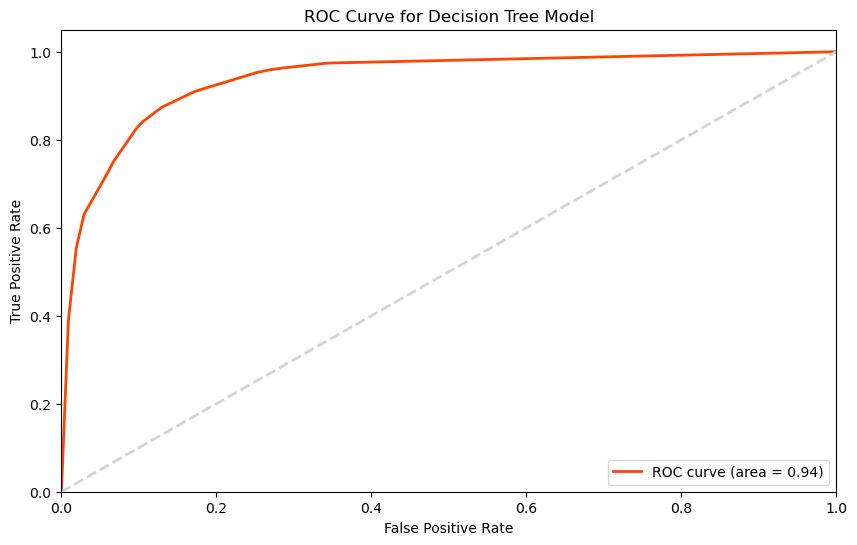

In [32]:
fpr, tpr, thresholds = roc_curve(y_orig_dt, y_probs_dt) #ROC curve points
roc_auc_dt = auc(fpr, tpr) # AUC

# Plottings
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='#ff4301', lw=2, label=f'ROC curve (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='lightgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Model')
plt.legend(loc="lower right")
plt.savefig("../../data/plots/ROC_dt_classification.png", dpi=300)
plt.show()